# Workflow step3: Mapping 1-electron time-overlaps to N-electrons ones

In this tutorial, we demonstrate how convert properties such as NACs and time-overlaps from the 1-electron (e.g. KS-) basis to the basis of Slater Determinants

## Table of contents
<a name="toc"></a>
1. [Mapping](#1)
2. [Ordering](#2)
3. [Determinant Reduction](#3)
4. [Time-Overlaps and Couplings](#4) 

### A. Learning objectives

* To map 1-electron properties to N-electron ones

### B. Use cases

* [Manually construct a Slater Determinant basis]()
* [Compute the energies and nonadiabatic couplings in the SD basis]()


### C. Functions

- `libra_py`
  - `workflows`
    - `nbra`
      - `mapping2`
        - [`sd2indx`](#sd2indx-1)
        - [`num_of_perms`](#num_of_perms-1)
        - [`reduce_determinants`](#reduce_determinants-1)
        - [`ovlp_arb`](#ovlp_arb-1)
        - [`ovlp_mat_arb`](#ovlp_mat_arb-1)
  - `data_conv`
    - [`nparray2CMATRIX`](#nparray2CMATRIX-1)    

In [1]:
import os
import sys
import time
import numpy as np

from liblibra_core import *
from libra_py.workflows.nbra import mapping2
from libra_py import data_conv, data_outs, data_stat, units

/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vect

## 1. Mapping <a name="1"></a>
[Back to TOC](#toc)

We start with the **user notation** for the Slater determinants. In many regards, the representation we use is similar to the Waller-Hartree double determinant representation [Pauncz, R. The Waller-Hartree double determinant in quantum chemistry. Int. J. Quantum Chem. 1989, 35, 717−719.]() or [Garniron, Y.; Applencourt, T.; Gasperich, K.; Benali, A.; Ferté, A.; Paquier, J.; Pradines, B.; Assaraf, R.; Reinhardt, P.; Toulouse, J.; Barbaresco, P.; Renon, N.; David, G.; Malrieu, J.-P.; Véril, M.; Caffarel, M.; Loos, P.-F.; Giner, E.; Scemama, A. Quantum Package 2.0: An Open-Source Determinant-Driven Suite of Programs. J. Chem. Theory Comput. 2019, 15, 3591–3609](https://doi.org/10.1021/acs.jctc.9b00176)

- SD are defined in terms of only one set of spatial orbitals $\phi$ - no differentiation by spin-components.

- In the **user notation**, the indices go from 1 to N, including the ends; in the **internal notation** they are running from 0 to N-1 including the ends

- The corresponding single-particle matrix is expected to be a N x N matrix

- Positive number $i$ corresponds to having an $\alpha$ electron on the orbital $i$

- Negative number $-i$ corresponds to having a $\beta$ electron on the orbital $i$


| Chemical notation | **User notation**  | Internal notation |
|---|---|---|
| $\phi_0$ | +/- 1 | 0 |
| $\phi_1$ | +/- 2 | 1 | 
| $\phi_2$ | +/- 3 | 2 |
| $\phi_3$ | +/- 4 | 3 |


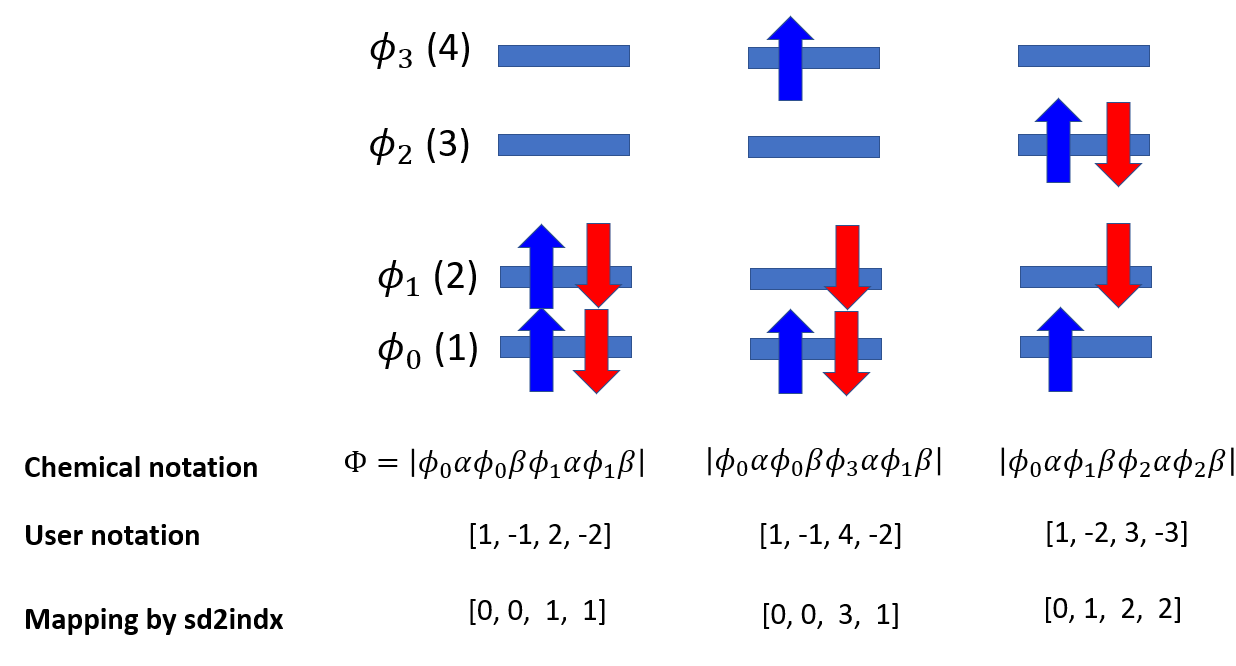

An example would be a system of 2 pairs of electrons on the first two orbitals:

$| \phi_0 \alpha \phi_1 \alpha \phi_0 \beta \phi_1 \beta |$ 

User notation: `[1, 2, -1, -2]` 

Internal mapping: `[0, 1, 0, 1]`
<a name="sd2indx-1"></a>

In [2]:
mapping2.sd2indx([1,2,-1,-2])

([0, 1, 0, 1], [0, 1], [0, 1])

In [3]:
help(mapping2.sd2indx)

Help on function sd2indx in module libra_py.workflows.nbra.mapping2:

sd2indx(sd)
    This function maps integers from the user that appear in the SD definition to internal indices
    
    Args:
        sd ( list of ints ): ids of the occupied orbitals in a given SD configuration. Indexing starts with 1, not 0!
    
            Positive numbers correspond to an alpha electron occupying the orbital
    
            Negative numbers correspond to a beta electron occupying the orbital
    
    Returns: 
        3 list of ints: the indices of the orbitals occupied in this SD in internal notation, the indexing starts from 0
             The first list - is for all orbitals, second - for alpha, and third - for beta
    
    Example: 
    
        Assume our active space consists of 2 orbitals: |1>,|2>
    
        One can then define 2-electron configurations like:  | 1a, 1b | or |1a, 2b|, etc.
    
        Here a and b refer to spin of electron occupying these orbitals
    
        On the 

## 2. Ordering <a name="2"></a>
[Back to TOC](#toc)

Note that the same configuration could be defined with the numbers taken in a different orders.  This ambiguity only affects the sign of the evaluated quantity. The sign itself should not matter, as long as the procedure is done consistently for all states and at every times.

For instance, the above state 

$| \phi_0 \alpha \phi_1 \alpha \phi_0 \beta \phi_1 \beta |$  ( user: `[1, 2, -1, 2]`; internal `[0, 1, 0, 1]`)

is equivalent to 

$| \phi_0 \alpha \phi_0 \beta \phi_1 \alpha \phi_1 \beta |$  ( user: `[1, -1, 2, -2]`; internal `[0, 0, 1, 1]`)

Hoever, the resulting calculations of let's say time-overlap woth some common determinant should encounter a sign flip. 

The sign of the wavefunction could be controlled by counting the number of permutations within alpha and beta channels.

For instance, for the two configurations, we can count the number of permutations in each spin-channel:
<a name="num_of_perms-1"></a>

In [4]:
sd1, sd1a, sd1b = mapping2.sd2indx([1,2,-1,-2])
print(sd1, sd1a, sd1b)
print(mapping2.num_of_perms(sd1) )

sd2, sd2a, sd2b = mapping2.sd2indx([1,-1,2,-2])
print(sd2, sd2a, sd2b)
print(mapping2.num_of_perms(sd2))

[0, 1, 0, 1] [0, 1] [0, 1]
1
[0, 0, 1, 1] [0, 1] [0, 1]
0


In [5]:
help(mapping2.num_of_perms)

Help on function num_of_perms in module libra_py.workflows.nbra.mapping2:

num_of_perms(x)
    This function computes the number of incorrectly ordered pairs in a sequence of numbers `x`
    
    Args:
        x ( list ): a sequence of numeric numbers
    
    Returns:
        int: the number of incorrectly ordered adjacent pairs of numbers



As we can see, the number of incorrect orderings in the first determinant is 1 and this number is 0 in the second determinant. Thus, the corresponding wavefunctions are different by the sign of (-1).

## 3. Determinant Reduction <a name="3"></a>
[Back to TOC](#toc)

Sometimes, the user definitions of Slater determinants are excessively large, especially when we need to compute hole dynamics. However,this would result it large matrices to be constructed before the determinant is evaluated. To reduce these costs, we can reduce the determinants before computing the time-overlaps. 
<a name="reduce_determinants-1"></a>

In [6]:
print(mapping2.reduce_determinants( [1, -1], [2, -2]))
print(mapping2.reduce_determinants( [3,-3, 1, -1], [3, -3, 2, -2]))
print(mapping2.reduce_determinants( [3,-3, 1, -1], [ 2, -2, 3, -3]))
print(mapping2.reduce_determinants( [1, -1, 2, -2, 3, -3], [1, -1, 2, -2, 3, -4]))


([1, -1], [2, -2])
([1, -1], [2, -2])
([1, -1], [2, -2])
([-3], [-4])


In [7]:
help(mapping2.reduce_determinants)

Help on function reduce_determinants in module libra_py.workflows.nbra.mapping2:

reduce_determinants(_sd1, _sd2)
    This function removes common parts of the two determinants
    
    Args:
        sd1, sd2 (lists of ints): determinants in the user representation
        
    Examples:
        >>  reduce_determinants( [1, -1], [2, -2])
        >>  ([1, -1], [2, -2])
    
        >>  reduce_determinants( [3,-3, 1, -1], [3, -3, 2, -2])
        >>  ([1, -1], [2, -2])
    
        >>  reduce_determinants( [1, -1, 2, -2, 3, -3], [1, -1, 2, -2, 3, -4])
        >>  ([-3], [-4])
    
    
    Returns:
        tuple of 2 lists: the reduced determinants



## 4. Time-Overlaps and Couplings <a name="4"></a>
[Back to TOC](#toc)

The reason why we needed the mapping function above is to map some properties in the basis of single-particle states (orbitals) to the basis of SD states.

[Akimov and Prezhdo](http://dx.doi.org/10.1021/ct400641n) and later [Ryabinkin and Izmaylov](https://doi.org/10.1021/acs.jpclett.5b02062) showed that for instance NACs in the SD basis can be directly mapped to the NACs in the KS basis

To demonstrate functions for such calculations, we consider the basis of SDs from the [our xTB paper](https://doi.org/10.1021/acs.jctc.2c00297)

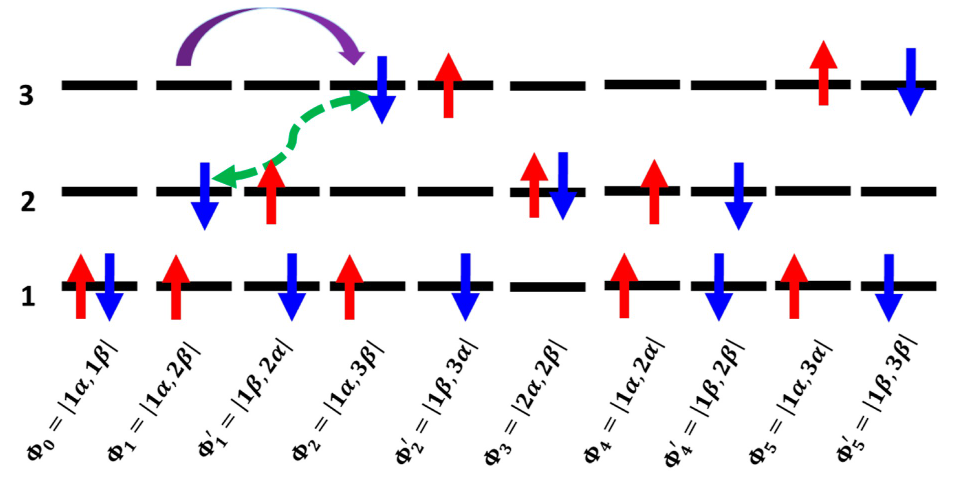

Let's say, in the RKS basis, the time-overlaps are like:
<a name="nparray2CMATRIX-1"></a>

In [8]:
st_rks = data_conv.nparray2CMATRIX( np.array( [ [-1.0, 1.0, 2.0], 
                                                [3.0, 4.0, 5.5], 
                                                [6.0, 7.0, 8.0]                                           
                                              ]  )
                                )

In [9]:
st_rks.real().show_matrix()

-1.0000000  1.0000000   2.0000000   
3.0000000   4.0000000   5.5000000   
6.0000000   7.0000000   8.0000000   



The NACs in the RKS basis are then:

In [10]:
d_rks = (st_rks - st_rks.H() )/2.0
d_rks.real().show_matrix()

0.0000000   -1.0000000  -2.0000000  
1.0000000   0.0000000   -0.75000000  
2.0000000   0.75000000  0.0000000   



Let's extend the RKS time-overlaps to the UKS format:

In [11]:
phi0 = [1, -1]
phi1 = [1, -2]
phi1p = [-1, 2]
phi2 = [1, -3]
phi2p = [-1, 3]
phi3 = [2, -2] 
phi4 = [1, 2]
phi4p = [-1, -2]
phi5 = [1, 3]
phi5p = [-1, -3]

basis = [ phi0, phi1, phi1p, phi2, phi2p, phi3, phi4, phi4p, phi5, phi5p]

The expected mapping of the NACs from the KS basis to the SD basis is as follows:

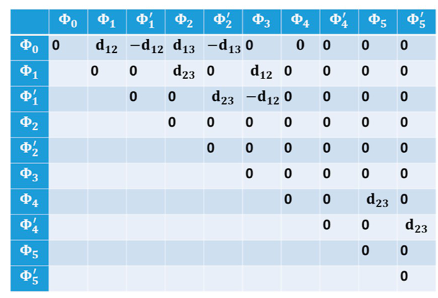


The time-overlaps between two individual determinants can be computed using `ovlp_arb(SD1, SD2, S, reduce_det=False)` function:
<a name="ovlp_arb-1"></a>

In [12]:
mapping2.ovlp_arb(phi0, phi1, st_rks, reduce_det=0)

(-1+0j)

In [13]:
help(mapping2.ovlp_arb)

Help on function ovlp_arb in module libra_py.workflows.nbra.mapping2:

ovlp_arb(SD1, SD2, S, reduce_det=False)
    Compute the overlap of two generic SDs: <SD1|SD2>
    
    Args:
    
        SD1 ( lists of ints ): first SD, such that:
            SeeAlso: ```inp``` in the ```sd2indx(inp)``` function
    
        SD2 ( lists of ints ): second SD, such that:
            SeeAlso: ```inp``` in the ```sd2indx(inp)``` function
    
        S ( CMATRIX(N,N) ): is the matrix in the space of 1-el orbital
    
        reduce_det ( Boolean ): If True, use the minimal distinct subset of orbitals needed to describe 
            the overlap of the SDs
    
    Returns:
        complex: the overlap of the two determinants <SD1|SD2>



Analogously, to compute a matrix of time-overlaps between different Slater determinants, we use the `ovlp_mat_arb(basis, basis, st_rks, reduce_det=0)` function:
<a name="ovlp_mat_arb-1"></a>

In [14]:
st = mapping2.ovlp_mat_arb(basis, basis, st_rks, reduce_det=0)
nac = (st - st.H() )/2.0
nac.real().show_matrix()

0.0000000   1.0000000   -1.0000000  2.0000000   -2.0000000  -4.0000000  0.0000000   0.0000000   0.0000000   0.0000000   
-1.0000000  0.0000000   0.0000000   0.75000000  0.0000000   -4.0000000  0.0000000   0.0000000   0.0000000   0.0000000   
1.0000000   0.0000000   0.0000000   0.0000000   0.75000000  4.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
-2.0000000  -0.75000000  0.0000000   0.0000000   0.0000000   -4.7500000  0.0000000   0.0000000   0.0000000   0.0000000   
2.0000000   0.0000000   -0.75000000  0.0000000   0.0000000   4.7500000   0.0000000   0.0000000   0.0000000   0.0000000   
4.0000000   4.0000000   -4.0000000  4.7500000   -4.7500000  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.75000000  0.0000000   
0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.75000000  
0.0000000   0.0000000   0.0000

In [15]:
help(mapping2.ovlp_mat_arb)

Help on function ovlp_mat_arb in module libra_py.workflows.nbra.mapping2:

ovlp_mat_arb(SD1, SD2, S, reduce_det=False)
    Compute a matrix of overlaps in the SD basis 
    
    Args:
        SD1 ( list of lists of N ints ): a list of N SD determinants, such that:
            SD1[iSD] is a list of integers defining which orbitals are 
            occupied in SD with index ```iSD``` and how 
            SeeAlso: ```inp``` in the ```sd2indx(inp)``` function
    
        SD2 ( list of lists of M ints ): a list of M SD determinants, such that:
            SD2[iSD] is a list of integers defining which orbitals are 
            occupied in SD with index ```iSD``` and how 
            SeeAlso: ```inp``` in the ```sd2indx(inp)``` function
    
        S ( CMATRIX(K,K) ): is the matrix in the full space of 1-el orbitals. Note - the mapped indices should not 
            be larger than K-1
    
        reduce_det ( Boolean ): If True, use the minimal subset of orbitals needed to describe 
      

Note that some matrix elements appear with the sign opposite to the one suggested by the table, but the relative signs are always correct. This sign flip is not a problem since it may also be related to the details of determinants representation. 

However, the present calculations also suggest that the second doubly-excited determinant $\Phi_3$ is coupled to the ground state determinants $\Phi_0$ as well as to the determinants $\Phi_2$ and $\Phi'_2$. These couplings were overlooked in the previous derivations but should still be present. Their magnitudes are of the second-order since they are related to a relative re-arrangement of two electrons. In realistic calculations, such couplings would be small. However, in the present example with rather arbitrary 1-electron time-overlaps, the first-order couplings are large, so the second-order couplings are even larger. 